## Using full mnist dataset and creating neural net from scratch

In [307]:
from fastai.vision.all import *
import inflect
from tqdm import tqdm
from fastai.data.core import DataLoaders

### Gathering data

In [63]:
path = untar_data(URLs.MNIST)

In [64]:
Path.BASE_PATH = path

In [65]:
(path/'training').ls().sorted()

(#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')]

Looping through training data and storing it in numbers dict

In [66]:
p = inflect.engine()
numbers = {}
for i in (path/'training').ls().sorted():
    num = str(i)[-1]
    for n in num:
        val = p.number_to_words(n)
        numbers[val] = (path/'training/{}'.format(n)).ls().sorted()

In [67]:
numbers_tensors = {}
for key, val in numbers.items():
    numbers_tensors[key] = [tensor(Image.open(o)) for o in val]

In [68]:
len(numbers_tensors['one']),len(numbers_tensors['two'])

(6742, 5958)

<AxesSubplot:>

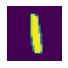

In [69]:
show_image(numbers_tensors['one'][10])

In [70]:
stacked_numbers = {}
for key, val in numbers_tensors.items():
    stacked_numbers[key] = torch.stack(numbers_tensors[key]).float()/255
stacked_numbers['one'].shape

torch.Size([6742, 28, 28])

In [71]:
valid_numbers = {}
for i in tqdm((path/'testing').ls().sorted()):
    num = str(i)[-1]
    for n in num:
        val = p.number_to_words(n)
        valid_numbers[val] = (path/'testing/{}'.format(n)).ls().sorted()
        valid_numbers[val] = torch.stack([tensor(Image.open(o)) for o in numbers[val]]).float()/255

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


In [72]:
valid_numbers['one'].shape

torch.Size([6742, 28, 28])

## Loading data into dataset

In [73]:
train_x = torch.cat([val for key, val in stacked_numbers.items()]).view(-1, 28*28)

In [219]:
def create_labels(pos,num):
    tns = torch.zeros([num,10])
    tns[:,pos] = 1
    return tns 

In [168]:
train_y = [create_labels(i,len(stacked_numbers[j])) for i,j in zip(range(len(stacked_numbers)),stacked_numbers)]
train_y = torch.cat(train_y)
train_y

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [165]:
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 10]))

In [130]:
dset = list(zip(train_x,train_y))
x,y = dset[0]


In [167]:
valid_x = torch.cat([val for key,val in valid_numbers.items()]).view(-1,28*28)
valid_y = [create_labels(i,len(valid_numbers[j])) for i,j in zip(range(len(valid_numbers)),valid_numbers)]
valid_y = torch.cat(valid_y)
valid_dset = list(zip(valid_x, valid_y))

## Beginnning to define model

In [81]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [257]:
weights = init_params((28*28,10))

In [260]:
bias = init_params(10)

In [261]:
weights.shape,bias.shape

(torch.Size([784, 10]), torch.Size([10]))

In [262]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-12.3567,  -2.2913,  -1.3011,  ...,  -2.0100,  12.9826, -15.6290],
        [ -6.9467,   7.2361,  -1.8526,  ...,  -1.0167,  10.8788, -12.5815],
        [-10.0010,   4.4673,  -8.8734,  ...,  -4.5361,  18.2508,  -9.3973],
        ...,
        [ -4.9072,  -1.3795,  -3.6923,  ...,  -0.7100,  -0.3441,  -0.9567],
        [-13.0981,   5.8797,  -0.7622,  ...,  -6.9162,  -2.0017,   0.3539],
        [ -1.2756,   0.9876,   2.1784,  ...,   5.6041,  -5.6511,  -1.6718]],
       grad_fn=<AddBackward0>)

### Defining Loss function

In [182]:
def mnist_loss(predictions, targets):
    #predictions = predictions.softmax(dim=1)
    target = torch.max(targets,1).indices
    #print(predictions,target)
    return nn.CrossEntropyLoss()(predictions,target)
    #loss = -(targets * predictions.log()).sum() / len(predictions)
    #return loss

In [263]:
mnist_loss(preds,train_y)

tensor(13.1406, grad_fn=<NllLossBackward>)

In [325]:
dl = DataLoader(dset, batch_size=128)
valid_dl = DataLoader(valid_dset, batch_size=128)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([128, 784]), torch.Size([128, 10]))

### Testing loss on small batch

In [220]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [221]:
preds = linear1(batch)
#preds

In [222]:
loss = mnist_loss(preds,train_y[:4])
loss

tensor(4.4697, grad_fn=<NllLossBackward>)

In [223]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [224]:
validate_epoch(linear1)

0.0684

### Defining functions to implement model

In [117]:
def calc_grad(xb,yb, model):
    preds = model(xb)
    loss = mnist_loss(preds,yb)
    loss.backward()

In [265]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb,yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [321]:
def batch_accuracy(xb, yb):
    preds = xb.softmax(dim=1)
    predVal, predMax = torch.max(preds.data,1)
    tarVal, tarMax = torch.max(yb,1)
    correct = predMax == tarMax
    return correct.float().mean()

In [120]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [266]:
lr = 1e-3
params = weights,bias

In [267]:
for i in range(40):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.0802 0.0893 0.1002 0.1118 0.1239 0.136 0.1473 0.1588 0.1713 0.183 0.1944 0.2055 0.2166 0.2274 0.2382 0.2486 0.258 0.2679 0.2771 0.2865 0.2951 0.3038 0.3124 0.3206 0.329 0.337 0.3454 0.3531 0.3609 0.3686 0.376 0.3829 0.3898 0.3966 0.4026 0.4093 0.4157 0.4218 0.4282 0.4347 

### Creating an Optimizer

In [285]:
linear_model = nn.Linear(28*28,10)

In [286]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [298]:
class BasicOptim:
    def __init__(self,params,lr):
        self.params,self,lr = list(params,lr)
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
        

In [288]:
opt = BasicOptim(linear_model.parameters(), lr)

In [289]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [290]:
validate_epoch(linear_model)

0.1102

In [291]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [297]:
train_model(linear_model, 20)

0.8654 0.8658 0.8662 0.8666 0.8668 0.8674 0.8679 0.8682 0.8687 0.8691 0.8695 0.8699 0.8705 0.8709 0.8711 0.8713 0.8716 0.8719 0.8722 0.8725 

In [330]:
linear_model = nn.Linear(28*28,10)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model,20)

0.2717 0.4292 0.5462 0.6244 0.6787 0.7146 0.7405 0.7597 0.7744 0.7853 0.7946 0.8026 0.8088 0.8149 0.8203 0.825 0.8293 0.8328 0.8356 0.8382 

In [327]:
dls = DataLoaders(dl, valid_dl)

In [332]:
learn = Learner(dls, nn.Linear(28*28,10), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [333]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,2.085621,2.000551,0.234533,00:01
1,1.685867,1.731693,0.419767,00:01
2,1.479280,1.512464,0.550950,00:01
3,1.339706,1.345891,0.631767,00:01
4,1.234882,1.219193,0.684483,00:01
5,1.152549,1.120834,0.719817,00:01
6,1.086104,1.042698,0.744383,00:01
7,1.031359,0.979292,0.762717,00:01
8,0.985468,0.926862,0.775983,00:01
9,0.946426,0.882794,0.787033,00:01


### Adding NonLinearity

In [334]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = xb@w2 + b2
    return res

In [335]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)
w1.shape,b1.shape

(torch.Size([784, 30]), torch.Size([30]))

In [341]:
simple_net = nn.Sequential(
    nn.Linear(28*28,128),
    nn.ReLU(),
    nn.Linear(128,10)
)

In [342]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [345]:
learn.fit(10,1e-3)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.026735,1.465477,0.623150,00:02
1,0.029747,1.412184,0.627750,00:01
2,0.032709,1.406483,0.622933,00:01
3,0.033204,1.364807,0.620950,00:01
4,0.032371,1.333750,0.624967,00:02
5,0.031524,1.320052,0.625333,00:02
6,0.030439,1.329984,0.619967,00:01
7,0.029477,1.350494,0.612583,00:01
8,0.028714,1.377560,0.605550,00:01
9,0.028474,1.375084,0.607650,00:01
